In [128]:
import numpy as np
import pandas as pd
from scipy import stats
import random
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

#from sklearn.model_selection import RandomizedSearchCV

In [53]:
#took first 6 million rows as my dataset.
data=pd.read_csv("C:/Users/Srishti/Desktop/dsf/all/train.csv",nrows=6000000)
#data.describe

In [54]:
#file_path="C:/Users/Srishti/Desktop/dsf/all/train.csv"
#total_size=sum(1 for line in open(file_path))
#reduced_size=5000000
#skip = sorted(random.sample(range(1,total_size),total_size-reduced_size))
#data = pd.read_csv(file_path, skiprows=skip,low_memory=False)

In [55]:
#checking for missing values
missing_values=data.isnull().sum()
print(missing_values)

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    39
dropoff_latitude     39
passenger_count       0
dtype: int64


In [56]:
#dropping missing values
data=data.dropna()

In [57]:
##checking for values where location coordinates are zero
data.loc[(data.dropoff_latitude == 0) & (data.dropoff_longitude == 0) & (data.pickup_latitude == 0) & (data.pickup_longitude == 0)].count()

key                  108501
fare_amount          108501
pickup_datetime      108501
pickup_longitude     108501
pickup_latitude      108501
dropoff_longitude    108501
dropoff_latitude     108501
passenger_count      108501
dtype: int64

In [58]:
#dropping rows where location coordinates are zero.
data=data.drop(data[(data.dropoff_latitude == 0) & (data.dropoff_longitude == 0) & (data.pickup_latitude == 0) & (data.pickup_longitude == 0)].index,axis=0)

In [59]:
#checking for rows where dropoff latitude and longitude values are zero
data.loc[(data.dropoff_latitude == 0) & (data.dropoff_longitude == 0) ].count()

key                  5074
fare_amount          5074
pickup_datetime      5074
pickup_longitude     5074
pickup_latitude      5074
dropoff_longitude    5074
dropoff_latitude     5074
passenger_count      5074
dtype: int64

In [60]:
#checking for rows where pickup latitude and longitude values are zero
data.loc[(data.pickup_latitude == 0) & (data.pickup_longitude == 0) ].count()

key                  5226
fare_amount          5226
pickup_datetime      5226
pickup_longitude     5226
pickup_latitude      5226
dropoff_longitude    5226
dropoff_latitude     5226
passenger_count      5226
dtype: int64

In [61]:
#dropping rows which are outside latitude range[39,42] and longitude[-75,-72] for both pickup and dropoff location
data=data.drop(data[(data.dropoff_latitude < 39) | (data.dropoff_longitude < -75) | (data.dropoff_latitude> 42) | (data.dropoff_longitude > -72)].index,axis=0)
data=data.drop(data[(data.pickup_latitude < 39) | (data.pickup_longitude < -75) | (data.pickup_latitude> 42) | (data.pickup_longitude > -72)].index,axis=0)

In [62]:
#imputing rows where dropoff latitute and longitude are zero with mean values. same for pickup.
data[(data.dropoff_latitude)==0]=data['dropoff_latitude'].mean()
data[(data.dropoff_longitude)==0]=data['dropoff_longitude'].mean()
data[(data.pickup_latitude)==0]=data['pickup_latitude'].mean()
data[(data.pickup_longitude)==0]=data['pickup_longitude'].mean()

In [63]:
#exploring fare_amount
data['fare_amount'].describe()

count    5.874752e+06
mean     1.132117e+01
std      9.706385e+00
min     -6.200000e+01
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      9.520000e+02
Name: fare_amount, dtype: float64

In [64]:
#checking rows with negative fare amount
data.loc[data.fare_amount<0].count()

key                  235
fare_amount          235
pickup_datetime      235
pickup_longitude     235
pickup_latitude      235
dropoff_longitude    235
dropoff_latitude     235
passenger_count      235
dtype: int64

In [65]:
#dropping rows with negative fare amount
data=data.drop(data[data.fare_amount<0].index,axis=0)

In [66]:
#exploring passenger count
data['passenger_count'].describe()

count    5.874517e+06
mean     1.684499e+00
std      1.314054e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.080000e+02
Name: passenger_count, dtype: float64

In [67]:
#dropping rows with passenger count greater than 6 because in nyc the maximum number of passengers a taxi can take is 5 plus a kid.
data=data.drop(data[(data.passenger_count>6)].index,axis=0)

In [68]:
#checking for rows where both passenger count and fare_amount=0
data.loc[(data.passenger_count==0) & (data.fare_amount==0)].count()

key                  1
fare_amount          1
pickup_datetime      1
pickup_longitude     1
pickup_latitude      1
dropoff_longitude    1
dropoff_latitude     1
passenger_count      1
dtype: int64

In [69]:
#dropping rows with both passenger count and fare amount=0
data=data.drop(data[(data.passenger_count==0) & (data.fare_amount==0)].index,axis=0)

In [70]:
#dropped rows with fare amount less than 2.5 since its a minimum charge.
data=data.drop(data[(data.fare_amount<2.5)].index,axis=0)

In [71]:
#calculating euclidean and haversine distance in kms
lat=data.dropoff_latitude-data.pickup_latitude
long=data.dropoff_longitude-data.pickup_longitude
#print(lat)
#print(long)
data['euclidean_distance']= np.sqrt(np.square(lat)+ np.square(long))
def haversine(lat1, lon1, lat2, lon2):

        R = 6371 #3959.8743 # this is in miles.  For Earth radius in kilometers use 6372.8 km

        dLat = np.radians(lat2 - lat1)
        dLon = np.radians(lon2 - lon1)
        lat1 = np.radians(lat1)
        lat2 = np.radians(lat2)

        a = np.sin(dLat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dLon/2)**2
        c = 2*np.arcsin(np.sqrt(a))

        return R * c
data['haversine_distance']=haversine(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)


In [72]:
#changing fare amount to base charge where euclidean distance is zero
data['fare_amount']=np.where((data['euclidean_distance']==0),2.5,data['fare_amount'])

#changing fare amount according to the distance travelled(haversine distance calculates in kms)(0.5$ for 0.321869 km +base charge)
data['fare_amount'] = np.where((data['haversine_distance']!=0) & (data['fare_amount']==0),data['haversine_distance']*(0.5/0.321869)+2.5,data['fare_amount'])

In [73]:
#correlation between euclidean distance and fare amount
np.corrcoef(data.euclidean_distance,data.fare_amount)

array([[1.        , 0.80526659],
       [0.80526659, 1.        ]])

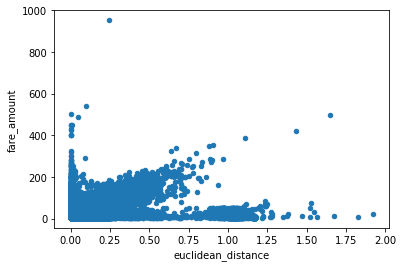

In [97]:
data.plot.scatter('euclidean_distance','fare_amount')

In [74]:
#correlation between haversine distance and fare amount
np.corrcoef(data.haversine_distance,data.fare_amount)

array([[1.        , 0.78441189],
       [0.78441189, 1.        ]])

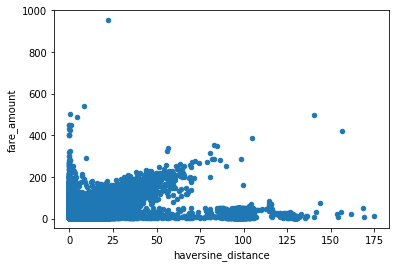

In [98]:
data.plot.scatter('haversine_distance','fare_amount')

In [75]:
#changing pickup_datetime column from string to datetime format
#data['date']=datetime.datetime.timezone.utc.strptime(data[i], "%y %b %d %h:%m:%s.%f")
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

In [77]:
#seperating date and time values 
data['date'] = [d.date() for d in data['pickup_datetime']]
data['time'] = [d.time() for d in data['pickup_datetime']]



In [80]:
#seperating time in hours, minutes and seconds
data['hour'] = data['time'].apply(lambda x: x.hour)
data['minutes'] = data['time'].apply(lambda x: x.minute)
data['seconds'] = data['time'].apply(lambda x: x.second)

In [82]:
#converting time into hours
data['time_converted']= data['hour'] + data['minutes']/60+ (data['seconds']/3600)

In [84]:
#correlation between time_converted and fare amount
np.corrcoef(data.time_converted,data.fare_amount)

array([[ 1.        , -0.01702299],
       [-0.01702299,  1.        ]])

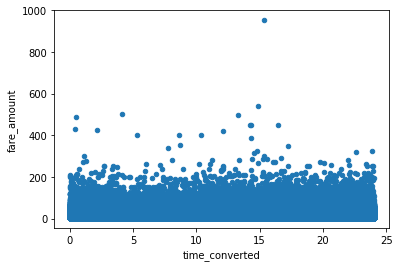

In [85]:
data.plot.scatter('time_converted','fare_amount')

In [86]:
#correlation between time_converted and euclidean distance
np.corrcoef(data.time_converted,data.euclidean_distance)

array([[ 1.      , -0.026412],
       [-0.026412,  1.      ]])

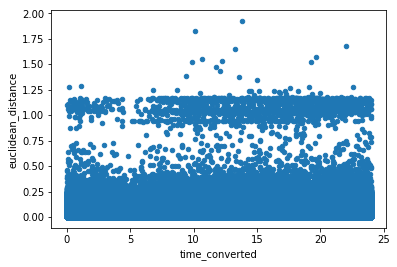

In [87]:
data.plot.scatter('time_converted','euclidean_distance')

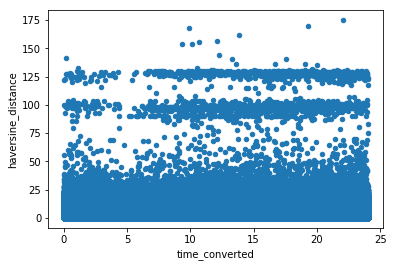

In [99]:
data.plot.scatter('time_converted','haversine_distance')

In [88]:
#calculating euclidean distance from the three aiports of nyc

jfk = (-73.7781, 40.6413)
new = (-74.1745, 40.6895)
lgr = (-73.8740, 40.7769)
langjfk_pickup=data['pickup_latitude']-jfk[1]
longjfk_pickup=data['pickup_longitude']-jfk[0]
langjfk_dropoff=data['dropoff_latitude']-jfk[1]
longjfk_dropoff=data['dropoff_longitude']-jfk[0]

langnew_pickup=data['pickup_latitude']-new[1]
longnew_pickup=data['pickup_longitude']-new[0]
langnew_dropoff=data['dropoff_latitude']-new[1]
longnew_dropoff=data['dropoff_longitude']-new[0]

langlgr_pickup=data['pickup_latitude']-lgr[1]
longlgr_pickup=data['pickup_longitude']-lgr[0]
langlgr_dropoff=data['dropoff_latitude']-lgr[1]
longlgr_dropoff=data['dropoff_longitude']-lgr[0]

data['pickup_distfromjfk']= np.sqrt(np.square(langjfk_pickup)+ np.square(longjfk_pickup))
data['dropoff_distfromjfk']= np.sqrt(np.square(langjfk_dropoff)+ np.square(longjfk_dropoff))

data['pickup_distfromnew']= np.sqrt(np.square(langnew_pickup)+ np.square(longnew_pickup))
data['dropoff_distfromnew']= np.sqrt(np.square(langnew_dropoff)+ np.square(longnew_dropoff))

data['pickup_distfromlgr']= np.sqrt(np.square(langlgr_pickup)+ np.square(longlgr_pickup))
data['dropoff_distfromlgr']= np.sqrt(np.square(langlgr_dropoff)+ np.square(longlgr_dropoff))



In [89]:
#loading test data, adding same features as training data
test_data=pd.read_csv("C:/Users/Srishti/Desktop/dsf/all/test.csv")
test_data=test_data.drop('key',axis=1)
#test_data=test_data.drop('pickup_datetime',axis=1)
test_data.dtypes
lat1=test_data.dropoff_latitude-test_data.pickup_latitude
long1=test_data.dropoff_longitude-test_data.pickup_longitude
#print(lat)
#print(long)
test_data['euclidean_distance']= np.sqrt(np.square(lat1)+ np.square(long1))
test_data['pickup_datetime'] = pd.to_datetime(test_data['pickup_datetime'])
test_data['date'] = [d.date() for d in test_data['pickup_datetime']]
test_data['time'] = [d.time() for d in test_data['pickup_datetime']]
test_data['hour'] = test_data['time'].apply(lambda x: x.hour)
test_data['minutes'] = test_data['time'].apply(lambda x: x.minute)
test_data['seconds'] = test_data['time'].apply(lambda x: x.second)
test_data['time_converted']= test_data['hour'] + test_data['minutes']/60+ (test_data['seconds']/3600)
test_data['haversine_distance']=haversine(test_data.pickup_latitude,test_data.pickup_longitude,test_data.dropoff_latitude,test_data.dropoff_longitude)

In [90]:
#calculating distance of each airport from test data coordinates.
langjfk_pickup_test=test_data['pickup_latitude']-jfk[1]
longjfk_pickup_test=test_data['pickup_longitude']-jfk[0]
langjfk_dropoff_test=test_data['dropoff_latitude']-jfk[1]
longjfk_dropoff_test=test_data['dropoff_longitude']-jfk[0]

langnew_pickup_test=test_data['pickup_latitude']-new[1]
longnew_pickup_test=test_data['pickup_longitude']-new[0]
langnew_dropoff_test=test_data['dropoff_latitude']-new[1]
longnew_dropoff_test=test_data['dropoff_longitude']-new[0]

langlgr_pickup_test=test_data['pickup_latitude']-lgr[1]
longlgr_pickup_test=test_data['pickup_longitude']-lgr[0]
langlgr_dropoff_test=test_data['dropoff_latitude']-lgr[1]
longlgr_dropoff_test=test_data['dropoff_longitude']-lgr[0]

test_data['pickup_distfromjfk']= np.sqrt(np.square(langjfk_pickup_test)+ np.square(longjfk_pickup_test))
test_data['dropoff_distfromjfk']= np.sqrt(np.square(langjfk_dropoff_test)+ np.square(longjfk_dropoff_test))

test_data['pickup_distfromnew']= np.sqrt(np.square(langnew_pickup_test)+ np.square(longnew_pickup_test))
test_data['dropoff_distfromnew']= np.sqrt(np.square(langnew_dropoff_test)+ np.square(longnew_dropoff_test))

test_data['pickup_distfromlgr']= np.sqrt(np.square(langlgr_pickup_test)+ np.square(longlgr_pickup_test))
test_data['dropoff_distfromlgr']= np.sqrt(np.square(langlgr_dropoff_test)+ np.square(longlgr_dropoff_test))



In [91]:
#making x and y dataframes for model
x=data.drop('fare_amount',axis=1)
x=x.drop('pickup_datetime',axis=1)
x=x.drop('key',axis=1)
x=x.drop('date',axis=1)
x=x.drop('time',axis=1)
#x=x.drop('hour',axis=1)
#y=test_data.drop('fare_amount',axis=1)
y=test_data.drop('pickup_datetime',axis=1)
#y=y.drop('key',axis=1)
y=y.drop('date',axis=1)
y=y.drop('time',axis=1)
#y=y.drop('hour',axis=1)
#x=x.drop('minutes',axis=1)
#x=x.drop('seconds',axis=1)
#x=x.drop('euclidean_distance',axis=1)
#x=x.drop('time_converted',axis=1)
#x.describe

In [92]:
#tried linear regression first, giving rmse of 5.4 in kaggle 

#sample.to_csv("C:/Users/Srishti/Desktop/dsf/all/sample_submission.csv")
#lr=LinearRegression()
#lr.fit(x,data['fare_amount'])
#sample=pd.read_csv("C:/Users/Srishti/Desktop/dsf/all1/sample_submission.csv")
#sample['fare_amount']=lr.predict(y)
#sample.to_csv("C:/Users/Srishti/Desktop/dsf/all/sample_submission4.csv",index=False)

#applying random forest regressor
rf = RandomForestRegressor()
rf.fit(x,data['fare_amount'])
sample=pd.read_csv("C:/Users/Srishti/Desktop/dsf/all1/sample_submission.csv")
sample['fare_amount']=rf.predict(y)
sample.to_csv("C:/Users/Srishti/Desktop/dsf/all/sample_submission4.csv",index=False)

In [96]:
#printing importance of each feature in our dataset.
feature_importance = pd.DataFrame(rf.feature_importances_,index = x.columns,columns=['importance']).sort_values('importance',ascending=False)
print(feature_importance)

                     importance
euclidean_distance     0.785866
dropoff_distfromjfk    0.030391
haversine_distance     0.026798
pickup_distfromjfk     0.019176
time_converted         0.016927
dropoff_latitude       0.016195
pickup_distfromlgr     0.013484
dropoff_longitude      0.013221
pickup_latitude        0.012858
dropoff_distfromlgr    0.012616
dropoff_distfromnew    0.012451
minutes                0.009900
pickup_longitude       0.008602
pickup_distfromnew     0.008171
seconds                0.006995
passenger_count        0.003443
hour                   0.002906


In [94]:
#data.loc[data.fare_amount==952]

In [95]:
#from sklearn.linear_model import Ridge
#clf = Ridge(alpha=1.0)
#clf.fit(x, data['fare_amount']) 
#sample=pd.read_csv("C:/Users/Srishti/Desktop/dsf/all1/sample_submission.csv")
#sample['fare_amount']=rf.predict(y)
#sample.to_csv("C:/Users/Srishti/Desktop/dsf/all/sample_submission5.csv",index=False)

In [125]:

data['coords']=np.sqrt(np.square(data['pickup_latitude'])+np.square(data['pickup_longitude']))


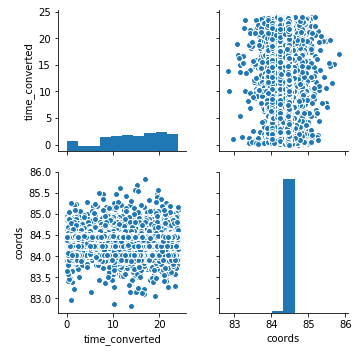

In [126]:
import seaborn as sb
plot=data[['time_converted','coords']].copy()
sb.pairplot(plot)